In [2]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *
from eibal import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
1+3

4

# Exploring the Structs with PDC Welch 
Here we will use the pre-computed spectral decompositions to plot the frequency range that most tracks E/I balance.
    According to the Voytek group this is the 30-50Hz range
    

In [ ]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/connectivity'
SUB_DIR = 'Epat34'
sub_paths= glob.glob(os.path.join(DATA_DIR, SUB_DIR, "*.mat"))


In [ ]:


# spectral_dfs = []

# freqs = sub_obj['pdc']['seizure']['pwelch_freqs']
# for key in spectral_keys:
#     decomps = sub_obj['pdc']['seizure'][key]
#     avg_decomp = np.mean(decomps, axis=0)
#     df = pd.DataFrame()
#     df['freq'] = freqs
#     df['welch'] = np.log(avg_decomp)
#     df['period'] = key
#     spectral_dfs.append(df)
# spectral_dfs = pd.concat(spectral_dfs)

In [ ]:
spectral_dfs = gen_global_peri_psd(sub_obj,spectral_keys)

In [ ]:
with sns.plotting_context("paper"):
    sns.lineplot(spectral_dfs, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)


In [ ]:
sub_obj['pdc']['seizure']['patID']

In [ ]:
for period in set(spectral_dfs.period):
    df = spectral_dfs[spectral_dfs.period == period]
    freqs = df.freq.values.reshape(-1,1)
    power = df.power.values.reshape(-1,1)
    slope = get_ei_slope(freqs, power)
    print(f"Period: {period} \nSlope: {slope}\n")

In [ ]:
len(sub_structs)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'gen')

In [ ]:
##Should be the same as above

with sns.plotting_context("paper"):
    sns.lineplot(peri_df, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'channel')

grp_df = peri_df.groupby(["freq",'labels','period']).mean().reset_index()

grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
grp_df

In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(grp_df,col='period',col_order=['interictal','pre','ictal','post']) 
        grid.map_dataframe(sns.lineplot, y='power',x='freq', hue='labels')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PSD on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_peri_psd.svg",transparent=True)

In [ ]:
contact_label = format_soz(sub_obj['pdc']['seizure']['soz_per_seizure'])
ei_df = get_reg_ei(sub_obj['pdc']['seizure'],spectral_keys,contact_label)
ei_df.period = ei_df.period.apply(lambda x : x.split("_")[-1])


In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(ei_df,col='period',col_order=['interictal','pre','post']) 
        grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_E_I_psd.svg",transparent=True)

In [ ]:
sub_list = [sub_path.split("/")[-2] for sub_path in sub_paths]
sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in sub_paths]

In [ ]:
sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))


In [ ]:
# from tqdm.notebook import tqdm
# sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))
# num_cores = 20
# ei_dfs = []
# count = 0
# for f_paths in tqdm(chunker(sub_paths, num_cores)):
#     structs = load_structs(f_paths,num_cores)
#     incl_inds = [i for i in range(len(structs)) if structs[i] != None]
#     structs = [structs[i] for i in incl_inds]

#     sub_list = [sub_path.split("/")[-2] for sub_path in f_paths]
#     sub_list = [sub_list[i] for i in incl_inds] #NOTE: god this is messy. TODO: fix struct chars for ID and sztype
#     sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in f_paths]
#     sz_list = [sz_list[i] for i in incl_inds]

#     res_dfs = get_reg_ei_para(structs, sub_list, sz_list, cores=num_cores)
#     ei_dfs.append(res_dfs)
#     count += 1
#     if count >5:
#         break
# ei_dfs = pd.concat(ei_dfs)


## Comparing E/I Distributions 

In [3]:
ei_dfs = pd.read_csv('../data/ei_bal.csv')

In [10]:
def resample_regions(res_df, reg_col):
    channel_counts = Counter(res_df[reg_col])
    n_samps = min(channel_counts.values())
    pz_df = res_df[res_df[reg_col] == 'PZ'].sample(n=n_samps, replace=True)

    soz_df = res_df[res_df[reg_col] == 'SOZ'].sample(n=n_samps, replace=True)

    niz_df = res_df[res_df[reg_col] == 'NIZ'].sample(n=n_samps, replace=True)

    return pd.concat([pz_df, soz_df, niz_df])

def get_stats_df(res_df):
    stats_df = pd.DataFrame(columns=['p_val','period'])
    for i, period in enumerate(set(res_df.period)):
        per_df = res_df[res_df.period == period]
        a = per_df[per_df.region == 'PZ'].e_i
        b = per_df[per_df.region == 'SOZ'].e_i
        c = per_df[per_df.region == 'NIZ'].e_i
        F, p = f_oneway(a, b, c)
        stats_df.loc[i] = [p, period]

    return stats_df

In [16]:
stats_df.groupby('period').mean()

,p_val,run
period,,
ictal,0.040339,15.5
interictal,0.545833,15.5
post,0.329640,15.5
pre,0.153238,15.5


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#e98d6b'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#e98d6b'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#e98d6b'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and w

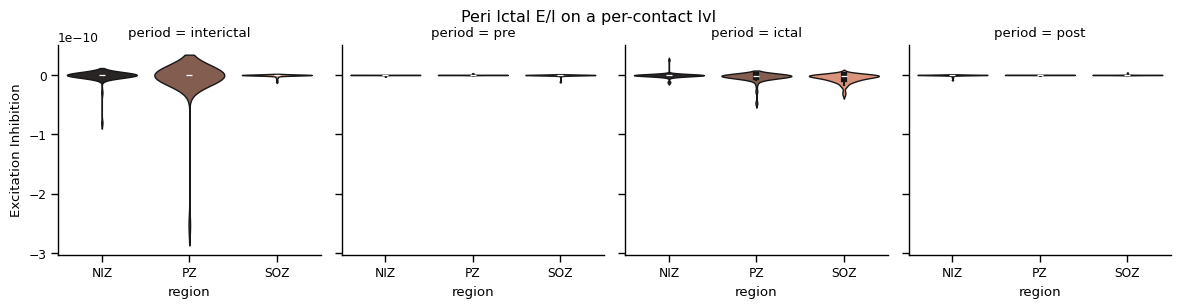

In [20]:
stats_df = []
for i in range(10):
    resamp_dfs = resample_regions(ei_dfs, 'region')
    grp_df= resamp_dfs[['e_i', 'region', 'period','subj']].groupby(['subj','region','period']).mean().reset_index()
    grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
    run_count +=1
    df = get_stats_df(grp_df)
    df['run'] = run_count
    stats_df.append(df)
stats_df = pd.concat(stats_df)
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(grp_df,col='period',col_order=['interictal','pre','ictal','post']) 

        grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
        grid.add_legend()
        grid.set_ylabels("Excitation Inhibition")
        grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_full_E_I_psd.svg",transparent=True)

In [ ]:
grp_df[['region','period','e_i']].groupby(['region','period']).mean()